<a href="https://colab.research.google.com/github/ZTatman/ACM-WebSite/blob/master/notebooks/dozer_object_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Real Time Object Detector  


##**Source**
Author: Alaa Sinjab  
url: https://towardsdatascience.com/detailed-tutorial-build-your-custom-real-time-object-detector-5ade1017fd2d

##**Introduction**
In this notebook, I follow Alaa Sinjab's tutorial on how to build a custom object detector.  
I use the **dozer dataset** I created in a [previous notebook](https://github.com/Ondaka/dozer-data/blob/master/notebooks/dozer_dataset.ipynb) to train my own object detector.   
<br/> 

The dozer dataset comes with a training and testing set. Each set contains masks, images,  
class annotations, and images of bulldozers objects alpha composed onto random backgrounds.  
<br/> 
The goal is to train a CNN model on sythentically generated images of bulldozers to recognize  
real life bulldozers.

## Necessary Packages

In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=31d64afc66087c4dea855bd93dd0dc48ba082d99db9a86d50050dfd030cac560
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [3]:
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk --fix-missing

!pip install -qq Cython contextlib2 pillow lxml matplotlib

!pip install -qq pycocotools

!pip install --upgrade tf_slim

Selecting previously unselected package python-bs4.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

## Necessary Imports

In [4]:
#  Switch to tensorflow 1.15.2
%tensorflow_version 1.x

from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
import csv

import re
import os
import io
import sys
import glob
import shutil
import zipfile
import urllib.request
import tarfile
import xml.etree.ElementTree as ET
import six.moves.urllib as urllib

import tensorflow
import tensorflow.compat.v1 as tf
import cv2 

from PIL import Image
from collections import namedtuple, OrderedDict, defaultdict
from IPython.display import display
from io import StringIO
from matplotlib import pyplot as plt


from google.colab import files
from google.colab import drive

print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


## Mount google drive

In [5]:
# Mount google drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
# Make a new directory
base_dir = "/object_detection"
os.mkdir(base_dir)
with zipfile.ZipFile("/content/gdrive/My Drive/dozer_dataset.zip", 'r') as zip_ref:
  
  # printing all the information of archive file contents  
  print('Exracting all...')
    
  zip_ref.extractall(base_dir)
  print('Done!') # check your directory of zip file to see the extracted files

Exracting all...
Done!


## Reorganize dozer dataset

In [7]:
src = '/object_detection/dozerdata/dataset'
dest = '/object_detection/data'
shutil.copytree(src, dest)

'/object_detection/data'

In [8]:
shutil.rmtree('/object_detection/dozerdata', ignore_errors=True)

## Define some helper functions

In [9]:
# Read csv file and return classnames as a set
def get_classes(path):
  class_names = []

  # Change the current working Directory
  try:
      os.chdir(path)
      print(f'Directory changed --> \'{path}\'')
  except OSError:
      print('Can\'t change the Current Working Directory')        

  with open('annotations.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line = 0
    
    # Read each row in the csv file
    for row in csv_reader:
      if line > 0:
        class_names.append(row[8])
        line += 1
      else:
        line += 1
    print(f'Processed {csv_reader.line_num} lines.')
    class_names = set(class_names)
    print(f'Classes: {class_names}')
    return class_names

def get_filenames(path):
  images = []
  masks = []

  # Change the current working Directory
  try:
      os.chdir(path)
      print(f'Directory changed --> \'{path}\'')
  except OSError:
      print('Can\'t change the Current Working Directory')        

  with open('annotations.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line = 0
    
    # Read each row in the csv file
    for row in csv_reader:
      if line > 0:
        images.append(row[1])
        masks.append(row[9])
        line += 1
      else:
        line += 1
    print(f'Processed {csv_reader.line_num} lines.')
    print(f'Images: {images[:5]}')
    print(f'Masks: {masks[:5]}')
    return images, masks

In [10]:
def create_pbtxt_file(path, classes):

  # Change the current working Directory
  try:
      os.chdir(path)
      print(f'Directory changed --> \'{path}\'')
  except OSError:
      print('Can\'t change the Current Working Directory') 

  label_map_path = os.path.join("label_map.pbtxt")
  pbtxt_content = ""

  for i, class_name in enumerate(classes):
      pbtxt_content = (
          pbtxt_content
          + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
      )

  pbtxt_content = pbtxt_content.strip()
  with open(label_map_path, "w") as f:
      f.write(pbtxt_content)
      print(f'Successfully created \'{label_map_path}\'')    

In [11]:
def get_tail(path):
  head, tail = os.path.split(path)
  return tail

def get_head(path):
  head, tail = os.path.split(path)
  return head

def replace_filenames_csv(path, col, filenames):
  values = [get_tail(f) for f in filenames]
  # print('\nValues: ', values[:5])
  df = pd.read_csv(path)

  # Find and replace values in the selected column
  df[col] = df[col].replace(filenames, values)
  # print(f'Dataframe: \n{df[col]}')
  # csv_path = get_head(path)
  # csv_path = os.path.join(csv_path, 'test.csv')
  # print(f'PATH: {csv_path}')
  df.to_csv(path, index=False) 

## Shorten the filenames in each annotations.csv

In [12]:
# Retrieve class names from test annotations.csv
path = '/object_detection/data/test/annotation'
test_classnames = get_classes(path)

# Retrieve class names from test annotations.csv
print()
images, masks = get_filenames(path)

# Replace long pathnames with just the filenames
replace_filenames_csv('/object_detection/data/test/annotation/annotations.csv', 'image', images)
replace_filenames_csv('/object_detection/data/test/annotation/annotations.csv', 'mask', masks)

Directory changed --> '/object_detection/data/test/annotation'
Processed 2001 lines.
Classes: {'bulldozer'}

Directory changed --> '/object_detection/data/test/annotation'
Processed 2001 lines.
Images: ['/dozerdata/Captures/test/generated/image_00000_gen.png', '/dozerdata/Captures/test/generated/image_00001_gen.png', '/dozerdata/Captures/test/generated/image_00002_gen.png', '/dozerdata/Captures/test/generated/image_00003_gen.png', '/dozerdata/Captures/test/generated/image_00004_gen.png']
Masks: ['/dozerdata/Captures/test/mask/image_00000_mask.png', '/dozerdata/Captures/test/mask/image_00001_mask.png', '/dozerdata/Captures/test/mask/image_00002_mask.png', '/dozerdata/Captures/test/mask/image_00003_mask.png', '/dozerdata/Captures/test/mask/image_00004_mask.png']


In [13]:
# Retrieve class names from train annotations.csv
path = '/object_detection/data/train/annotation'
train_classnames = get_classes(path)

# Retrieve class names from train annotations.csv
print()
images, masks = get_filenames(path)

# Replace long pathnames with just the filenames
replace_filenames_csv('/object_detection/data/train/annotation/annotations.csv', 'image', images)
replace_filenames_csv('/object_detection/data/train/annotation/annotations.csv', 'mask', masks)


print()
create_pbtxt_file('/object_detection/data', train_classnames)

Directory changed --> '/object_detection/data/train/annotation'
Processed 10000 lines.
Classes: {'bulldozer'}

Directory changed --> '/object_detection/data/train/annotation'
Processed 10000 lines.
Images: ['/dozerdata/Captures/train/generated/image_00000_gen.png', '/dozerdata/Captures/train/generated/image_00001_gen.png', '/dozerdata/Captures/train/generated/image_00002_gen.png', '/dozerdata/Captures/train/generated/image_00003_gen.png', '/dozerdata/Captures/train/generated/image_00004_gen.png']
Masks: ['/dozerdata/Captures/train/mask/image_00000_mask.png', '/dozerdata/Captures/train/mask/image_00001_mask.png', '/dozerdata/Captures/train/mask/image_00002_mask.png', '/dozerdata/Captures/train/mask/image_00003_mask.png', '/dozerdata/Captures/train/mask/image_00004_mask.png']

Directory changed --> '/object_detection/data'
Successfully created 'label_map.pbtxt'


## Check that each image has a valid bounding box

In [14]:
#checks if the images box position is placed within the image.

#note: while this doesn't checks if the boxes/annotatoins are correctly
# placed around the object, Tensorflow will through an error if this occured.

# path to images
train_path = '/object_detection/data/train/generated'
# test_path = '/object_detection/data/test/generated'

#loops over both train_labels and test_labels csv files to do the check
# returns the image name where an error is found 
# return the incorrect attributes; xmin, ymin, xmax, ymax.
# for CSV_FILE in ['/object_detection/data/train/annotation/annotations.csv', '/object_detection/data/test/annotation/annotations.csv']:
CSV_FILE = '/object_detection/data/train/annotation/annotations.csv'
with open(CSV_FILE, 'r') as fid:  
    print('[*] Checking file:', CSV_FILE) 
    file = csv.reader(fid, delimiter=',')
    first = True 
    cnt = 0
    error_cnt = 0
    error = False
    for row in file:
        if error == True:
            error_cnt += 1
            error = False         
        if first == True:
            first = False
            continue     
        cnt += 1      
        name, width, height, xmin, ymin, xmax, ymax = row[1], int(row[2]), int(row[3]), int(row[4]), int(row[5]), int(row[6]), int(row[7])     
        path = os.path.join(train_path, name)
        img = Image.open(path)       
        if type(img) == type(None):
            error = True
            print('Could not read image', img)
            continue
        org_width, org_height = img.size     
        if org_width != width:
            error = True
            print('Width mismatch for image: ', name, width, '!=', org_width)
            print(f'IMG SIZE: {img.size}, width: {org_width}')     
            
        if org_height != height:
            error = True
            print('Height mismatch for image: ', name, height, '!=', org_height) 
            print(f'IMG SIZE: {img.size}, height: {org_height}')     
        
        if xmin > org_width:
            error = True
            print('XMIN > org_width for file', name)  
            print(f'IMG SIZE: {img.size}, XMIN: {xmin}')     
        
        if xmax > org_width:
            error = True
            print('XMAX > org_width for file', name)
            print(f'IMG SIZE: {img.size}, XMAX: {xmax}')     
        
        if ymin > org_height:
            error = True
            print('YMIN > org_height for file', name)
            print(f'IMG SIZE: {img.size}, YMIN: {ymin}')     
        
        if ymax > org_height:
            error = True
            print('YMAX > org_height for file', name)
            print(f'IMG SIZE: {img.size}, YMAX: {ymax}')     
        
        if error == True:
            print('Error for file: %s' % name)
            print(f'IMG SIZE: {img.size}')     
            print()
    print()
    print('Checked %d files and realized %d errors' % (cnt, error_cnt))
    print("-----")

[*] Checking file: /object_detection/data/train/annotation/annotations.csv

Checked 9999 files and realized 0 errors
-----


In [15]:
#checks if the images box position is placed within the image.

#note: while this doesn't checks if the boxes/annotatoins are correctly
# placed around the object, Tensorflow will through an error if this occured.

# path to images
# train_path = '/object_detection/data/train/generated'
test_path = '/object_detection/data/test/generated'

#loops over both train_labels and test_labels csv files to do the check
# returns the image name where an error is found 
# return the incorrect attributes; xmin, ymin, xmax, ymax.
# for CSV_FILE in ['/object_detection/data/train/annotation/annotations.csv', '/object_detection/data/test/annotation/annotations.csv']:
CSV_FILE = '/object_detection/data/test/annotation/annotations.csv'
with open(CSV_FILE, 'r') as fid:  
    print('[*] Checking file:', CSV_FILE) 
    file = csv.reader(fid, delimiter=',')
    first = True 
    cnt = 0
    error_cnt = 0
    error = False
    for row in file:
        if error == True:
            error_cnt += 1
            error = False         
        if first == True:
            first = False
            continue     
        cnt += 1      
        name, width, height, xmin, ymin, xmax, ymax = row[1], int(row[2]), int(row[3]), int(row[4]), int(row[5]), int(row[6]), int(row[7])     
        path = os.path.join(test_path, name)
        img = Image.open(path)       
        if type(img) == type(None):
            error = True
            print('Could not read image', img)
            continue
        org_width, org_height = img.size     
        if org_width != width:
            error = True
            print('Width mismatch for image: ', name, width, '!=', org_width)
            print(f'IMG SIZE: {img.size}, width: {org_width}')     
            
        if org_height != height:
            error = True
            print('Height mismatch for image: ', name, height, '!=', org_height) 
            print(f'IMG SIZE: {img.size}, height: {org_height}')     
        
        if xmin > org_width:
            error = True
            print('XMIN > org_width for file', name)  
            print(f'IMG SIZE: {img.size}, XMIN: {xmin}')     
        
        if xmax > org_width:
            error = True
            print('XMAX > org_width for file', name)
            print(f'IMG SIZE: {img.size}, XMAX: {xmax}')     
        
        if ymin > org_height:
            error = True
            print('YMIN > org_height for file', name)
            print(f'IMG SIZE: {img.size}, YMIN: {ymin}')     
        
        if ymax > org_height:
            error = True
            print('YMAX > org_height for file', name)
            print(f'IMG SIZE: {img.size}, YMAX: {ymax}')     
        
        if error == True:
            print('Error for file: %s' % name)
            print(f'IMG SIZE: {img.size}')     
            print()
    print()
    print('Checked %d files and realized %d errors' % (cnt, error_cnt))
    print("-----")

[*] Checking file: /object_detection/data/test/annotation/annotations.csv

Checked 2000 files and realized 0 errors
-----


## Downloading and Preparing Tensorflow model
1. Cloning [Tensorflow models](https://github.com/tensorflow/models.git) from the offical git repo. The repo contains the object detection API we are interseted in. 
2. Compiling the protos and adding folders to the os environment.
3. Testing the model builder.

In [16]:
# navigate to object detection directory
try:
    os.chdir('/object_detection')
    print('Directory changed --> \'/object_detection\'')
except OSError:
    print('Can\'t change the Current Working Directory') 

Directory changed --> '/object_detection'


In [17]:
# Downlaods Tenorflow
!git clone --q https://github.com/tensorflow/models.git

In [18]:
# navigate to object detection directory
try:
    os.chdir('/object_detection/models/research')
    print('Directory changed --> \'/object_detection/models/research\'')
except OSError:
    print('Can\'t change the Current Working Directory') 

Directory changed --> '/object_detection/models/research'


In [19]:
#compiling the proto buffers (not important to understand for this project but you can learn more about them here: https://developers.google.com/protocol-buffers/)
!protoc object_detection/protos/*.proto --python_out=.

# exports the PYTHONPATH environment variable with the reasearch and slim folders' paths
os.environ['PYTHONPATH'] += ':/object_detection/models/research/:/object_detection/models/research/slim/'

# Install the object detection package
!pip install .

Processing /object_detection/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1318546 sha256=6b6fb3a1353a34516be040512438f86f2e2ee6a22985f8907be601112e74d5d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-a2xdzwy5/wheels/2d/40/de/077413f89dd86526e24458d9a5c245e151e8b5459f0a85c6f4
Successfully built object-detection


## Test Tensorflow model installation

In [20]:
# navigate to 'object_detection/models/research' directory
try:
    os.chdir('/object_detection/models/research')
    print('Directory changed --> \'/object_detection/models/research\'')
    print(f'Current Working Directory: {os.getcwd()}')
except OSError:
    print('Can\'t change the Current Working Directory') 

Directory changed --> '/object_detection/models/research'
Current Working Directory: /object_detection/models/research


In [21]:
print(os.getcwd())

/object_detection/models/research


In [22]:
# testing the model builder
!python3 object_detection/builders/model_builder_test.py

## Create TF record files for csv in train and test set

In [23]:
#adjusted from: https://github.com/datitran/raccoon_dataset

# converts the csv files for training and testing data to two TFRecords files.
# places the output in the same directory as the input

from object_detection.utils import dataset_util 


def class_text_to_int(row_label):
  if row_label == 'bulldozer':
    return 1
  else:
    None

def split(df, group):
		data = namedtuple('data', ['filename', 'object'])
		gb = df.groupby(group)
		return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
		with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
				encoded_jpg = fid.read()
		encoded_jpg_io = io.BytesIO(encoded_jpg)
		image = Image.open(encoded_jpg_io)
		width, height = image.size

		filename = group.filename.encode('utf8')
		image_format = b'jpg'
		xmins = []
		xmaxs = []
		ymins = []
		ymaxs = []
		classes_text = []
		classes = []

		for index, row in group.object.iterrows():
				xmins.append(row['xmin'] / width)
				xmaxs.append(row['xmax'] / width)
				ymins.append(row['ymin'] / height)
				ymaxs.append(row['ymax'] / height)
				classes_text.append(row['class'].encode('utf8'))
				classes.append(class_text_to_int(row['class']))

		tf_example = tf.train.Example(features=tf.train.Features(feature={
				'image/height': dataset_util.int64_feature(height),
				'image/width': dataset_util.int64_feature(width),
				'image/filename': dataset_util.bytes_feature(filename),
				'image/source_id': dataset_util.bytes_feature(filename),
				'image/encoded': dataset_util.bytes_feature(encoded_jpg),
				'image/format': dataset_util.bytes_feature(image_format),
				'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
				'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
				'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
				'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
				'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
				'image/object/class/label': dataset_util.int64_list_feature(classes),
		}))
		return tf_example

In [24]:
# Change this to the base directory where your data/ is 
data_base_url = '/object_detection/data'

# Location of images
train_dir = os.path.join(data_base_url, 'train/generated')
test_dir = os.path.join(data_base_url, 'test/generated')

# Locations of annotations
train_ann = os.path.join(data_base_url, 'train/annotation')
test_ann = os.path.join(data_base_url, 'test/annotation')




# Create TF record for train set
writer = tf.io.TFRecordWriter(train_ann + '/annotations' + '.record')
path = os.path.join(train_dir)
examples = pd.read_csv(train_ann + '/annotations' + '.csv')
grouped = split(examples, 'image')
for group in grouped:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())
    
writer.close()
output_path = os.path.join(os.getcwd(), train_ann + '/annotations' + '.record')
print('Successfully created the TFRecords: {}'.format(train_ann + '/annotations' + '.record'))

Successfully created the TFRecords: /object_detection/data/train/annotation/annotations.record


In [25]:
# Create TF record for train set
writer = tf.io.TFRecordWriter(test_ann + '/annotations' + '.record')
path = os.path.join(test_dir)
examples = pd.read_csv(test_ann + '/annotations' + '.csv')
grouped = split(examples, 'image')
for group in grouped:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())
    
writer.close()
output_path = os.path.join(os.getcwd(), test_ann + '/annotations' + '.record')
print('Successfully created the TFRecords: {}'.format(test_ann + '/annotations' + '.record'))

Successfully created the TFRecords: /object_detection/data/test/annotation/annotations.record


## Download the base model

In [26]:
# navigate to 'object_detection/models/research' directory
try:
    os.chdir('/object_detection/models/research')
    print('Directory changed --> \'/object_detection/models/research\'')
    print(f'Current Working Directory: {os.getcwd()}')
except OSError:
    print('Can\'t change the Current Working Directory') 

Directory changed --> '/object_detection/models/research'
Current Working Directory: /object_detection/models/research


In [27]:
# Some models to train on
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
    }
}

# Select a model in `MODELS_CONFIG`.
# I chose ssd_mobilenet_v2 for this project, you could choose any
selected_model = 'ssd_mobilenet_v2'

In [28]:
# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

#selecting the model
MODEL_FILE = MODEL + '.tar.gz'

#creating the downlaod link for the model selected
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

#the distination folder where the model will be saved
fine_tune_dir = '/object_detection/models/research/pretrained_model'

#checks if the model has already been downloaded
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

#unzipping the file and extracting its content
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# creating an output file to save the model while training
os.remove(MODEL_FILE)
if (os.path.exists(fine_tune_dir)):
    shutil.rmtree(fine_tune_dir)
os.rename(MODEL, fine_tune_dir)

In [29]:
#checking the content of the pretrained model.
# this is the directory of the "fine_tune_checkpoint" that is used in the config file.
!echo {fine_tune_dir}
!ls -alh {fine_tune_dir}

/object_detection/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 23 root   root  4.0K Aug 12 16:14 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


## Configuring the Training Pipeline
1. Adding the path for the TFRecords files and pbtxt,batch_size,num_steps,num_classes to the configuration file.
2. Adding some Image augmentation.
3. Creating a directory to save the model at each checkpoint while training. 

In [30]:
# The path to the folder containing all the sample config files
CONFIG_BASE = "/object_detection/models/research/object_detection/samples/configs/"

# Path to the specified model's config file
model_pipline = os.path.join(CONFIG_BASE, pipeline_file)
model_pipline

'/object_detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config'

In [31]:
#check the sample config file that is provided by the tf model
!cat /object_detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 90
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect

In [32]:
# Editing the configuration file to add the path for the TFRecords files, pbtxt,batch_size,num_steps,num_classes.
# Any image augmentation, hyperparemeter tunning (drop out, batch normalization... etc) would be editted here

%%writefile {model_pipline}
model {
  ssd {
    num_classes: 1 # number of classes to be detected
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
      }
    }
    # all images will be resized to the below W x H.
    image_resizer { 
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    box_predictor {
      convolutional_box_predictor {
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        #use_dropout: false
        use_dropout: true # to counter over fitting. you can also try tweaking its probability below
        dropout_keep_probability: 0.8
        kernel_size: 1
        box_code_size: 4
        apply_sigmoid_to_scores: false
        conv_hyperparams {
          activation: RELU_6,
          regularizer {
            l2_regularizer {
            # weight: 0.00004
            weight: 0.001 # higher regularizition to counter overfitting
          }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.03
              mean: 0.0
            }
          }
          batch_norm {
            train: true,
            scale: true,
            center: true,
            decay: 0.9997,
            epsilon: 0.001,
          }
        }
      }
    }
    feature_extractor {
      type: 'ssd_mobilenet_v2'
      min_depth: 16
      depth_multiplier: 1.0
      conv_hyperparams {
        activation: RELU_6,
        regularizer {
          l2_regularizer {
            # weight: 0.00004
            weight: 0.001 # higher regularizition to counter overfitting
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          train: true,
          scale: true,
          center: true,
          decay: 0.9997,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid {
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000 
        iou_threshold: 0.95
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 3
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        
        #adjust this to the max number of objects per class. 
        # ex, in my case, I have one pistol in most of the images.
        # . there are some images with more than one up to 16.
        max_detections_per_class: 16
        # max number of detections among all classes. I have 1 class only so
        max_total_detections: 16
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  batch_size: 10 # training batch size
  optimizer {
    rms_prop_optimizer: {
      learning_rate: {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.003
          decay_steps: 800720
          decay_factor: 0.95
        }
      }
      momentum_optimizer_value: 0.9
      decay: 0.9
      epsilon: 1.0
    }
  }

  #the path to the pretrained model. 
  fine_tune_checkpoint: "/object_detection/models/research/pretrained_model/model.ckpt"
  fine_tune_checkpoint_type:  "detection"
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 100000 
  

  #data augmentaion is done here, you can remove or add more.
  # They will help the model generalize but the training time will increase greatly by using more data augmentation.
  # Check this link to add more image augmentation: https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto
  
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_adjust_contrast {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    #path to the training TFRecord
    input_path: "/object_detection/data/train/annotation/annotations.record"
  }
  #path to the label map 
  label_map_path: "/object_detection/data/label_map.pbtxt"
}

eval_config: {
  # the number of images in your "testing" data (was 600 but we removed one above :) )
  num_examples: 2000
  # the number of images to disply in Tensorboard while training
  num_visualizations: 20

  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  # max_evals: 10
}

eval_input_reader: {
  tf_record_input_reader {
      
    #path to the testing TFRecord
    input_path: "/object_detection/data/test/annotation/annotations.record"
  }
  #path to the label map 
  label_map_path: "/object_detection/data/label_map.pbtxt"
  shuffle: false
  num_readers: 1
}

Overwriting /object_detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config


In [33]:
# where the model will be saved at each checkpoint while training 
model_dir = 'training/'

# Optionally: remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Tensorboard
1. Downlaoding and unzipping Tensorboard
2. creating a link to visualize multiple graph while training.


notes: 
  1. Tensorboard will not log any files until the training starts. 
  2. a max of 20 connection per minute is allowed when using ngrok, you will not be able to access tensorboard while the model is logging.

In [34]:
#downlaoding ngrok to be able to access tensorboard on google colab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-08-12 16:15:43--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 100.24.239.43, 54.84.72.55, 52.22.53.129, ...
Connecting to bin.equinox.io (bin.equinox.io)|100.24.239.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  6.58MB/s    in 2.0s    

2020-08-12 16:15:46 (6.58 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [35]:
#the logs that are created while training 
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

In [36]:
#The link to tensorboard.
#works after the training starts.

### note: if you didnt get a link as output, rerun this cell and the one above
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://06fb655468b0.ngrok.io


## Training

Finally training the model!


In [61]:
# Check the amount of RAM available for use before training
printm()

Gen RAM Free: 24.6 GB  | Proc size: 2.6 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [62]:
!python3 /object_detection/models/research/object_detection/model_main.py \
    --pipeline_config_path={model_pipline}\
    --model_dir={model_dir} \
    --alsologtostderr \

Streaming output truncated to the last 5000 lines.
INFO:tensorflow:loss = 1.9881401, step = 34200 (22.395 sec)
I0811 18:51:06.604996 140086705313664 basic_session_run_hooks.py:260] loss = 1.9881401, step = 34200 (22.395 sec)
INFO:tensorflow:global_step/sec: 4.45746
I0811 18:51:29.038419 140086705313664 basic_session_run_hooks.py:692] global_step/sec: 4.45746
INFO:tensorflow:loss = 1.7689395, step = 34300 (22.435 sec)
I0811 18:51:29.039699 140086705313664 basic_session_run_hooks.py:260] loss = 1.7689395, step = 34300 (22.435 sec)
INFO:tensorflow:global_step/sec: 4.43509
I0811 18:51:51.585803 140086705313664 basic_session_run_hooks.py:692] global_step/sec: 4.43509
INFO:tensorflow:loss = 2.4192748, step = 34400 (22.547 sec)
I0811 18:51:51.586864 140086705313664 basic_session_run_hooks.py:260] loss = 2.4192748, step = 34400 (22.547 sec)
INFO:tensorflow:global_step/sec: 4.44504
I0811 18:52:14.082731 140086705313664 basic_session_run_hooks.py:692] global_step/sec: 4.44504
INFO:tensorflow:los

In [63]:
# Check ram usage again
printm()

Gen RAM Free: 24.2 GB  | Proc size: 2.6 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


## Exporting The Trained model



In [64]:

#the location where the exported model will be saved in.
output_directory = '/object_detection/models/research/fine_tuned_model'

# goes through the model is the training/ dir and gets the last one.
# you could choose a specfic one instead of the last
lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')
last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

#exports the model specifed and inference graph
!python /object_detection/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={model_pipline} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-100000
Instructions for updating:
Please use `layer.__call__` method instead.
W0812 00:43:07.326049 139743798527872 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0812 00:43:10.001774 139743798527872 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0812 00:43:10.050894 139743798527872 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0812 00:43:10.219568 139743798527872 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:de

In [118]:
#downloads the frozen model that is needed for inference
files.download(output_directory + '/frozen_inference_graph.pb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [119]:
#downlaod the label map
files.download(data_base_url + '/label_map.pbtxt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference on Image

In [41]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized


def draw_bounding_box_on_image(image,
                           ymin,
                           xmin,
                           ymax,
                           xmax,
                           color='white',
                           thickness=8,
                           display_str_list=('Bulldozer'),
                           use_normalized_coordinates=True):
  """Adds a bounding box to an image.
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  Each string in display_str_list is displayed on a separate line above the
  bounding box in black text on a rectangle filled with the input 'color'.
  If the top of the bounding box extends to the edge of the image, the strings
  are displayed below the bounding box.
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: list of strings to display in box
                      (each to be shown on its own line).
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  print(f'Image size: {image.size}')
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  draw = ImageDraw.Draw(image).rectangle((left, right, top, bottom), fill=None, outline ="green")
  # draw = ImageDraw.Draw(image).rectangle((top, left, bottom, right), fill=None, outline ="red")
  plt.figure(figsize=(8,8))
  plt.imshow(image)
  plt.show()

    

In [42]:
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Import object detection module
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from google.colab.patches import cv2_imshow
# # patch tf1 into `utils.ops`
# print(utils_ops.tf)

# # Patch the location of gfile
tf.gfile = tf.io.gfile

image_np shape: 270000
Boxes: [0.5285969  0.5711073  0.7260331  0.73817056], Shape: (4,)
Scores: [0.98188984], Shape: (1,) 
Classes: [1.], Shape: ()
Num Detections: [1.]


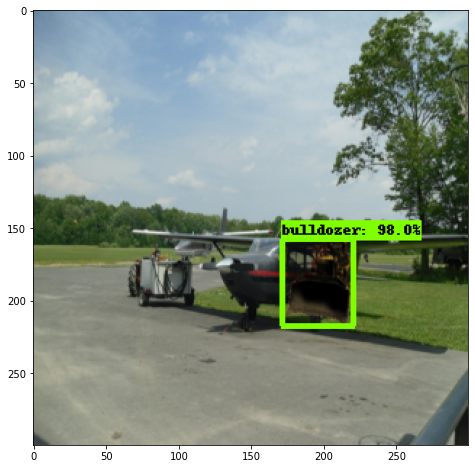

image_np shape: 270000
Boxes: [0.22981656 0.5946356  0.42277354 0.84040296], Shape: (4,)
Scores: [0.9996685], Shape: (1,) 
Classes: [1.], Shape: ()
Num Detections: [1.]


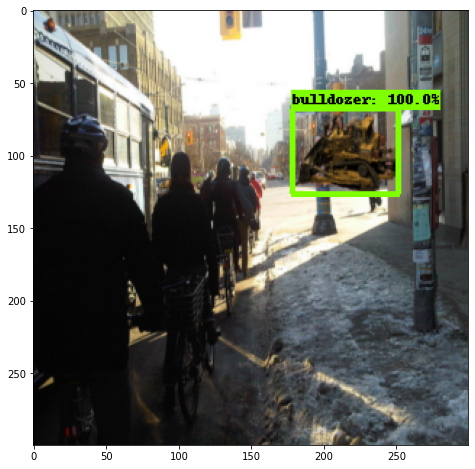

image_np shape: 270000
Boxes: [0.2587962  0.15700996 0.46806154 0.38293958], Shape: (4,)
Scores: [0.99227583], Shape: (1,) 
Classes: [1.], Shape: ()
Num Detections: [1.]


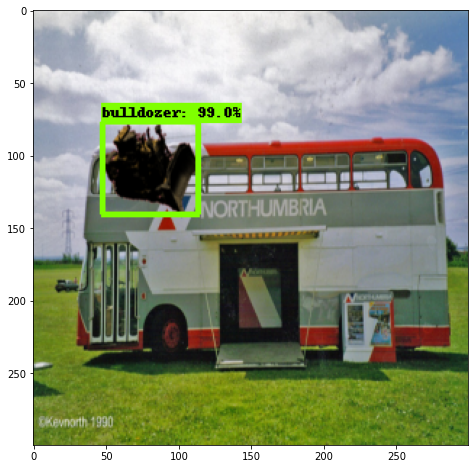

image_np shape: 270000
Boxes: [0.5101876  0.31497088 0.75847936 0.62319314], Shape: (4,)
Scores: [0.99800175], Shape: (1,) 
Classes: [1.], Shape: ()
Num Detections: [1.]


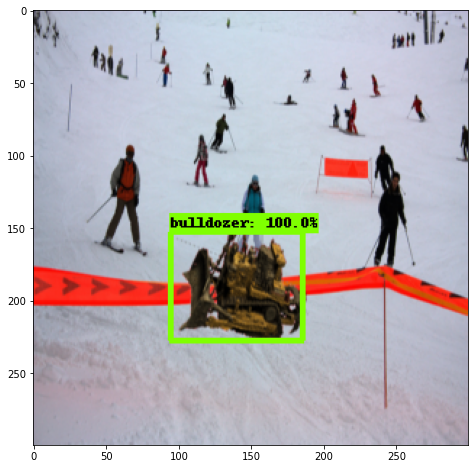

image_np shape: 270000
Boxes: [0.45926982 0.65956706 0.747436   0.9913139 ], Shape: (4,)
Scores: [0.9997039], Shape: (1,) 
Classes: [1.], Shape: ()
Num Detections: [1.]


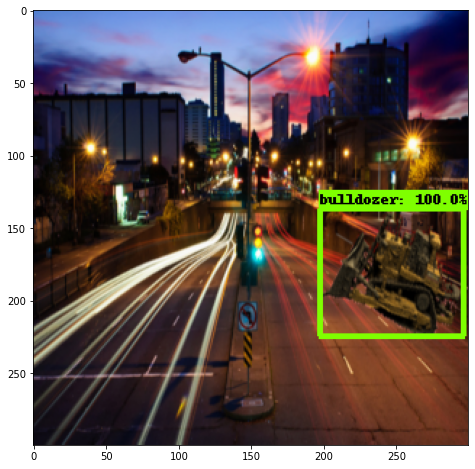

In [68]:
%matplotlib inline
# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
# PATH_TO_CHKPT = '/object_detection/models/research/fine_tuned_model/frozen_inference_graph.pb'
PATH_TO_CHKPT = '/content/gdrive/My Drive/Inferenece_Graphs/frozen_inference_graph (2).pb'
# Path to label map file
PATH_TO_LABELS = '/object_detection/data/label_map.pbtxt'

# Path to image
TEST_IMAGE_PATHS = ['/object_detection/data/test/generated/image_00000_gen.png','/object_detection/data/test/generated/image_00001_gen.png','/object_detection/data/test/generated/image_00002_gen.png','/object_detection/data/test/generated/image_00003_gen.png','/object_detection/data/test/generated/image_00004_gen.png']
# TEST_IMAGE_PATHS = ['/content/gdrive/My Drive/Test_Images/img1.png', '/content/gdrive/My Drive/Test_Images/img2.png', '/content/gdrive/My Drive/Test_Images/img3.png', '/content/gdrive/My Drive/Test_Images/img4.png', '/content/gdrive/My Drive/Test_Images/img5.png', '/content/gdrive/My Drive/Test_Images/img6.png']


# PATH_TO_IMAGE = '/content/gdrive/My Drive/Test_Images/img1.png',
# PATH_TO_IMAGE_2 = '/object_detection/data/test/generated/image_00000_gen.png'

# Number of classes the object detector can identify
NUM_CLASSES = 1

IMAGE_SIZE = (300, 300)

# Load the label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
# print(f'Categories: {categories}')
category_index = label_map_util.create_category_index(categories)
# print(f'Category Index: {category_index}')

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CHKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
    with tf.Session(graph=detection_graph) as sess:
      for image_path in TEST_IMAGE_PATHS:
        image = cv2.imread(image_path)
        image = cv2.resize(image, IMAGE_SIZE)
        # image = cv2.GaussianBlur(image, (5,5), 0)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image_np = np.array(image_pil)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        scores = detection_graph.get_tensor_by_name('detection_scores:0')
        classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        # Actual detection.
        (boxes, scores, classes, num_detections) = sess.run(
            [boxes, scores, classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        print(f'image_np shape: {image_np.size}')
        print(f'Boxes: {np.squeeze(boxes)}, Shape: {np.squeeze(boxes).shape}')
        print(f'Scores: {np.squeeze(scores).reshape((1,))}, Shape: {np.squeeze(scores).reshape((1,)).shape} ')
        print(f'Classes: {np.squeeze(classes).reshape((1,))}, Shape: {np.squeeze(classes).shape}')
        print(f'Num Detections: {num_detections}')
        # print(f'Image expanded squeezed Dim: {np.squeeze(image_expanded).shape}')
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes).reshape((1,4)),
            np.squeeze(classes).reshape((1,)).astype(np.int32),
            np.squeeze(scores).reshape((1,)),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=4, min_score_thresh=0)
        # image_pil = Image.fromarray(image_np,'RGB')
        # draw_bounding_box_on_image(image_pil, boxes[0][0][0], boxes[0][0][1], boxes[0][0][2], boxes[0][0][3])
        plt.figure(figsize=(8,8))
        plt.imshow(image_np)
        plt.show()

# # Press any key to close the image
# # cv2.waitKey(0)

# # # Clean up
# # cv2.destroyAllWindows()